## Performance Evaluation

### Univariate Model

In [218]:
%run mpl_config.py

In [219]:
import os
import pandas as pd
import numpy as np

from eda_helper import get_custom_palette, get_custom_heatmap, get_custom_colormap

custom_palette = get_custom_palette()
custom_heatmap = get_custom_heatmap()
custom_colormap = get_custom_colormap()

print(os.getcwd())

c:\#code\#python\#current\mres-project\analysis_files


In [220]:
print(os.getcwd())
print(type(os.getcwd()))

c:\#code\#python\#current\mres-project\analysis_files
<class 'str'>


In [221]:
os.path.join(str(os.getcwd()), "/runtime_metrics_um.csv")

'c:/runtime_metrics_um.csv'

In [222]:
print(os.path.join(os.getcwd(), "/runtime_metrics_um.csv"))

c:/runtime_metrics_um.csv


In [223]:
cwd = os.getcwd()

In [224]:
performance = pd.read_csv(cwd + "\\test_data\\performance_metrics_um.csv")
runtime = pd.read_csv(cwd + "\\test_data\\runtime_um.csv")

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns

In [226]:
performance.columns

Index(['MAE', 'MSE', 'RMSE', 'R^2', 'Model', 'Training Time (s)',
       'Completeness', 'WindowSize', 'Horizon'],
      dtype='object')

In [227]:
performance_lstm = performance[performance["Model"] == "LSTM"]
performance_lstm = performance_lstm[
    [
        "MAE",
        "MSE",
        "RMSE",
        "R^2",
        "Training Time (s)",
        "Completeness",
        "WindowSize",
        "Horizon",
    ]
]

data = performance_lstm.sort_values(by="R^2").reset_index(drop=True)
data

,MAE,MSE,RMSE,R^2,Training Time (s),Completeness,WindowSize,Horizon
0,0.884617,1.112276,0.940541,-0.018289,25.368120,1.00,96,24
1,0.791741,1.006611,0.889798,0.006713,4.080466,1.00,3,24
2,0.754281,0.878551,0.868493,0.134368,5.298277,1.00,6,24
3,0.736026,0.815639,0.857919,0.185520,24.038941,0.96,3,24
4,0.753207,0.807636,0.867875,0.194397,13.169937,0.98,3,24
...,...,...,...,...,...,...,...,...
163,0.174327,0.082811,0.417525,0.917767,411.628916,0.94,96,3
164,0.178149,0.075253,0.422077,0.925450,167.495548,0.98,192,3
165,0.176762,0.074405,0.420431,0.925782,36.217134,0.98,24,3
166,0.176806,0.073650,0.420483,0.926867,91.880642,0.98,96,3


In [228]:
sorted_performance = data.sort_values(by="Training Time (s)").reset_index(drop=True)
sorted_performance = sorted_performance.groupby(
    ["Completeness", "Horizon", "WindowSize"]
).mean()
sorted_performance.reset_index(inplace=True)
sorted_performance

,Completeness,Horizon,WindowSize,MAE,MSE,RMSE,R^2,Training Time (s)
0,0.94,3,3,0.228615,0.126689,0.478137,0.873350,114.085268
1,0.94,3,6,0.212222,0.111254,0.460675,0.888811,131.812231
2,0.94,3,12,0.198999,0.101548,0.446093,0.898560,171.646432
3,0.94,3,24,0.183112,0.085232,0.427916,0.914908,300.452003
4,0.94,3,48,0.181871,0.088486,0.426463,0.911789,319.064008
...,...,...,...,...,...,...,...,...
163,1.00,96,12,0.407766,0.385313,0.638566,0.644836,6.351154
164,1.00,96,24,0.404646,0.344751,0.636118,0.684380,8.599739
165,1.00,96,48,0.396220,0.346875,0.629460,0.688511,13.252820
166,1.00,96,96,0.393211,0.355611,0.627065,0.694373,22.821535


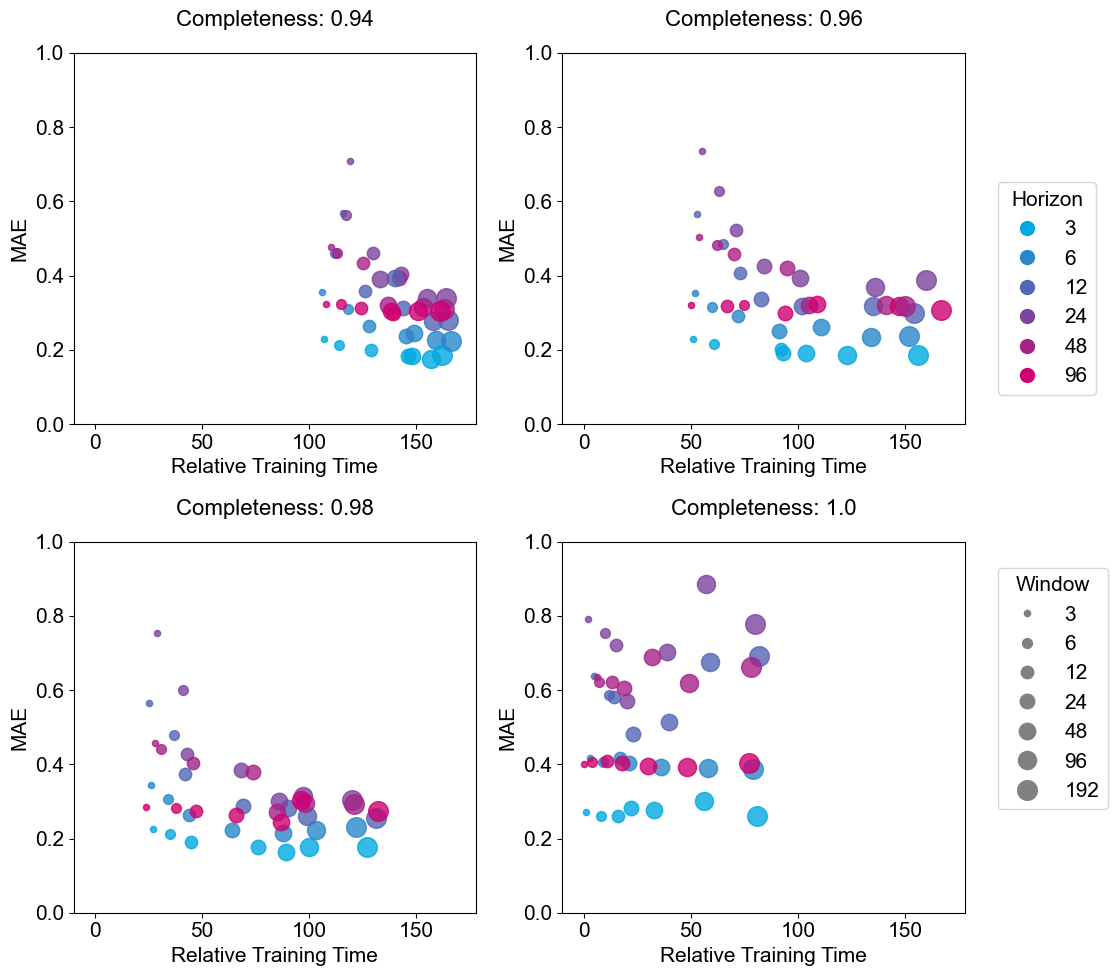

In [229]:
sorted_performance = performance_lstm.sort_values(by="Training Time (s)").reset_index(
    drop=True
)

window_values = np.sort(sorted_performance["WindowSize"].unique())
horizon_values = np.sort(sorted_performance["Horizon"].unique())
completeness_values = np.sort(sorted_performance["Completeness"].unique())

# Swap colors for horizon and sizes for window values
colors = custom_heatmap(np.linspace(0, 1, len(horizon_values)))
size_values = np.linspace(20, 200, len(window_values))

color_legend_elements = []  # For color legend (horizons)
size_legend_elements = []  # For size legend (window sizes)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.ravel()  # Flatten the array of axes to loop through

for k, completeness in enumerate(completeness_values):
    ax = axs[k]
    for i, window_size in enumerate(window_values):
        for j, horizon in enumerate(horizon_values):
            data = sorted_performance[
                (sorted_performance["WindowSize"] == window_size)
                & (sorted_performance["Horizon"] == horizon)
                & (sorted_performance["Completeness"] == completeness)
            ]["MAE"]

            ax.scatter(
                data.index,
                data,
                s=size_values[i],
                color=colors[j],
                marker="o",
                alpha=0.8,
            )

            # Populating the legend elements
            if k == 0:  # Only do this once
                if i == 0:
                    color_legend_elements.append(
                        plt.Line2D(
                            [0],
                            [0],
                            color=colors[j],
                            marker="o",
                            linestyle="",
                            markersize=10,
                            label=horizon,
                        )
                    )
                if j == 0:
                    size_legend_elements.append(
                        plt.Line2D(
                            [0],
                            [0],
                            color="grey",
                            marker="o",
                            linestyle="",
                            markersize=size_values[i] ** 0.5,
                            label=window_size,
                        )
                    )

    # Set titles, labels for each subplot
    ax.set_title(f"Completeness: {completeness}", y=1.05)
    ax.set_xlabel("Relative Training Time")
    ax.set_ylabel("MAE")
    ax.set_ylim(0, 1)
    ax.set_xlim(-10, 168 + 10)

# Adding a shared legend outside of the whole figure
fig.legend(
    handles=color_legend_elements,
    title="Horizon",
    loc="center left",
    bbox_to_anchor=(1, 0.7),
)
fig.legend(
    handles=size_legend_elements,
    title="Window",
    loc="center left",
    bbox_to_anchor=(1, 0.3),
)

plt.tight_layout()
plt.show()

In [230]:
performance_lstm.reset_index(drop=True, inplace=True)

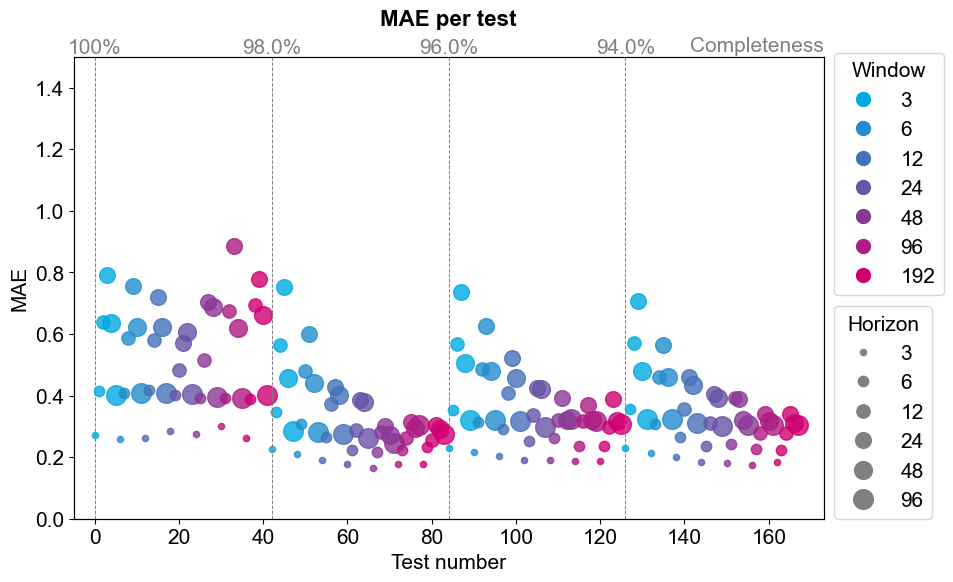

In [238]:
# Adjust the figure size to provide space on the right for the legends
fig, ax = plt.subplots(figsize=(12, 6))
window_values = performance_lstm["WindowSize"].unique()
horizon_values = performance_lstm["Horizon"].unique()

colors = custom_heatmap(np.linspace(0, 1, len(window_values)))
size_values = np.linspace(20, 200, len(horizon_values))

color_legend_elements = []  # For color legend (window sizes)
size_legend_elements = []  # For size legend (horizons)

for i, window_size in enumerate(window_values):
    for j, horizon in enumerate(horizon_values):
        data = performance_lstm[
            (performance_lstm["WindowSize"] == window_size)
            & (performance_lstm["Horizon"] == horizon)
        ]["MAE"]

        ax.scatter(
            data.index, data, s=size_values[j], color=colors[i], marker="o", alpha=0.8
        )

        if j == 0:
            color_legend_elements.append(
                plt.Line2D(
                    [0],
                    [0],
                    color=colors[i],
                    marker="o",
                    linestyle="",
                    markersize=10,
                    label=window_size,
                )
            )
        if i == 0:
            size_legend_elements.append(
                plt.Line2D(
                    [0],
                    [0],
                    color="grey",
                    marker="o",
                    linestyle="",
                    markersize=size_values[j] ** 0.5,
                    label=horizon,
                )
            )

# Adjusted the position of legends to the right of the plot
color_legend = ax.legend(
    handles=size_legend_elements,
    title="Horizon",
    loc="center left",
    bbox_to_anchor=(1, 0.23),
)
ax.add_artist(color_legend)
ax.legend(
    handles=color_legend_elements,
    title="Window",
    loc="upper left",
    bbox_to_anchor=(1, 1.03),
)
ax.set_xlabel("Test number")
ax.set_ylabel("MAE")
ax.set_title("MAE per test", y=1.05, fontweight="bold")
ax.set_ylim(0, 1.5)
ax.set_xlim(-5, len(sorted_performance) + 5)

# Add vertical lines every 84 intervals and label them
max_index = performance_lstm.index.max()
for x, c in zip(range(0, max_index, 42), [1, 0.98, 0.96, 0.94]):
    ax.axvline(x, color="grey", linestyle="--", linewidth=0.7)
    ax.text(
        x, ax.get_ylim()[1], str(f"{c*100}%"), va="bottom", ha="center", color="grey"
    )

# Add a twin x-axis for the top label
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([])  # Hide the ticks
ax2.set_xticklabels([])
ax2.set_xlabel("Completeness", loc="right", color="grey")

plt.subplots_adjust(
    right=0.75
)  # Adjust subplot so there's space for legends on the right
plt.show()

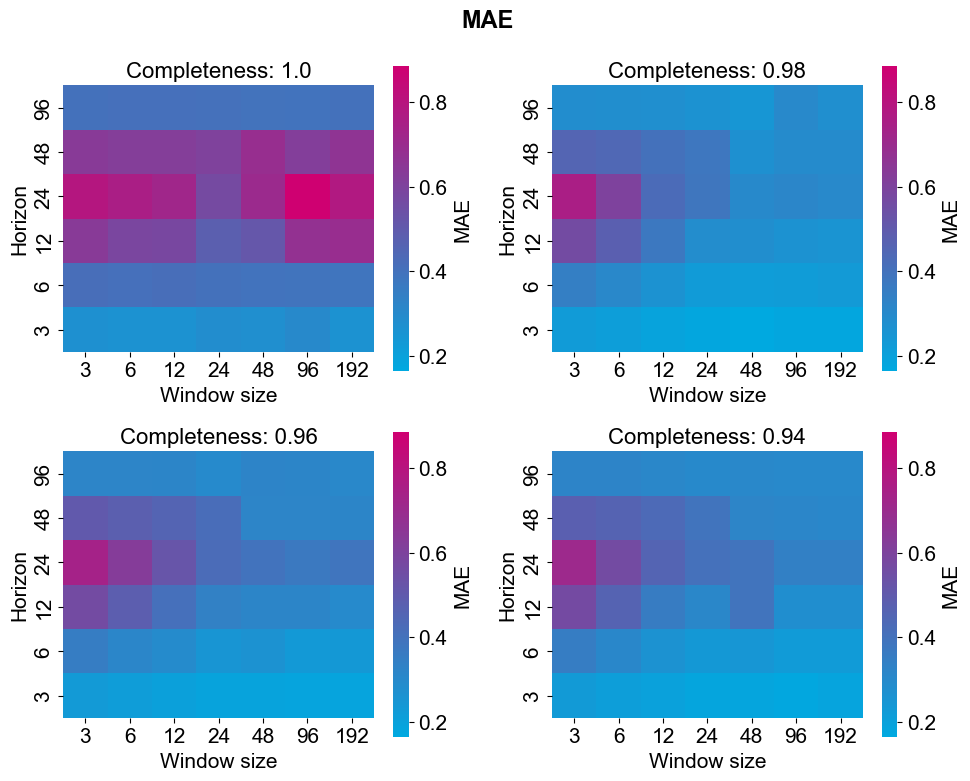

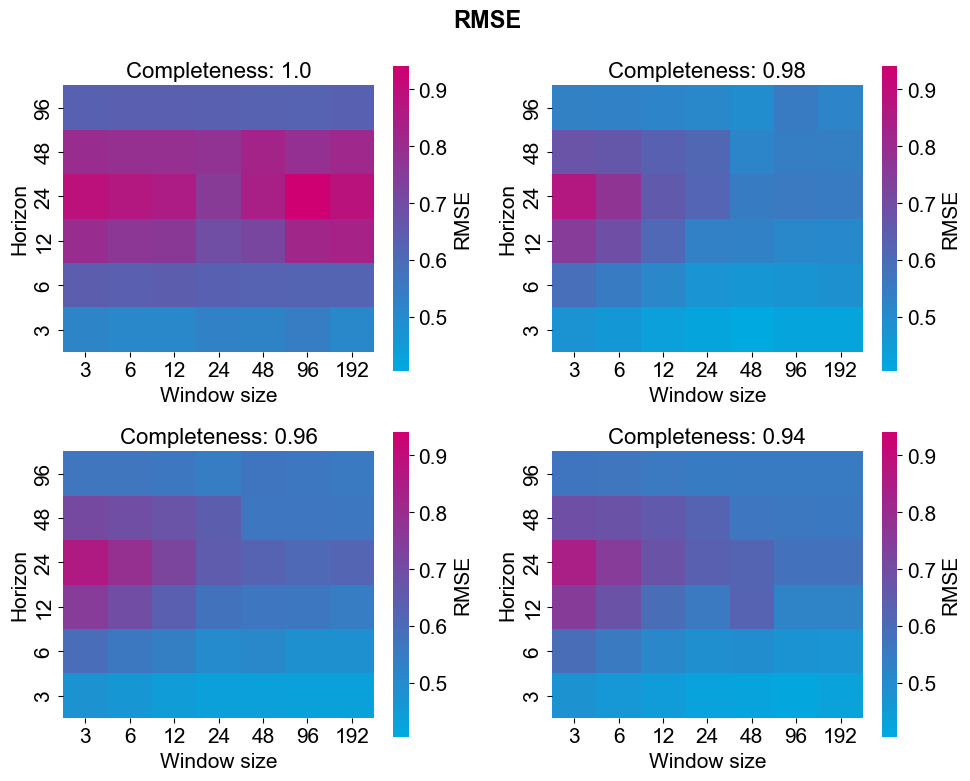

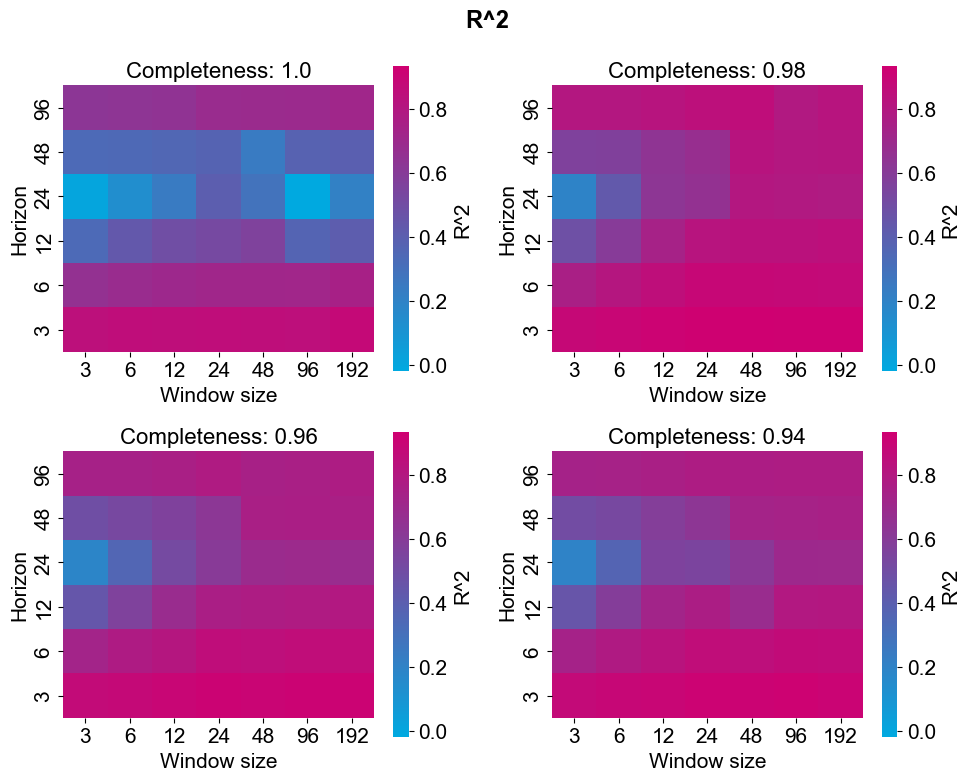

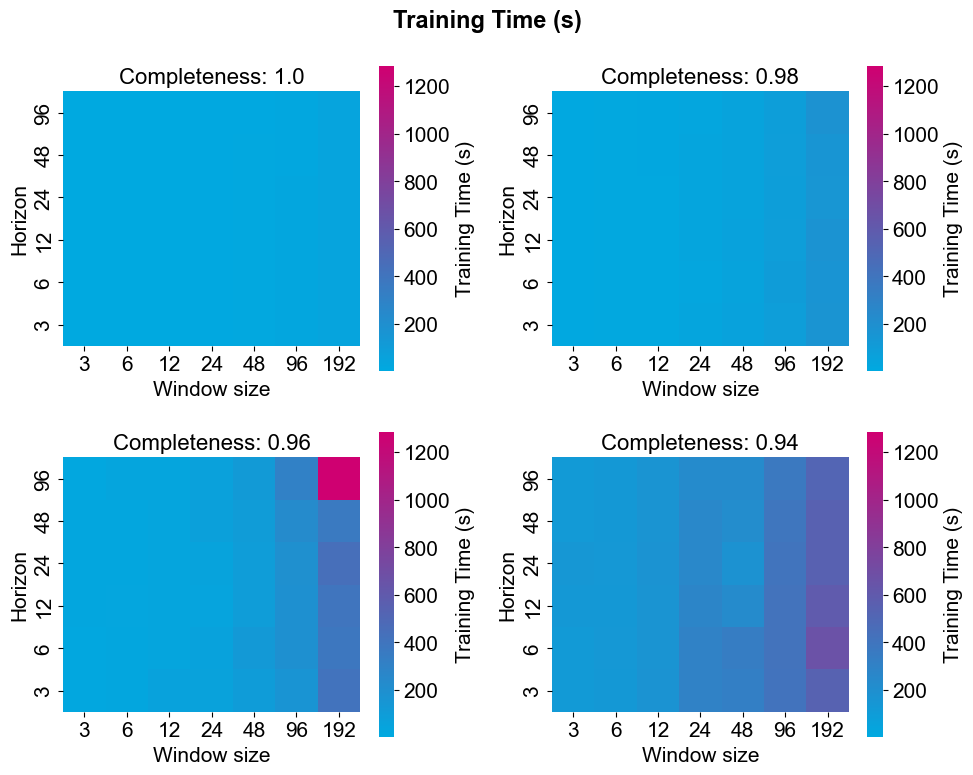

In [232]:
for metric in ["MAE", "RMSE", "R^2", "Training Time (s)"]:
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))

    # Calculate global vmin and vmax for the metric
    vmin = performance_lstm[metric].min()
    vmax = performance_lstm[metric].max()

    # Loop over all completeness values
    for i, completeness in enumerate(performance_lstm["Completeness"].unique()):
        # Subset
        subset = performance_lstm[performance_lstm["Completeness"] == completeness]

        # Pivot table for heatmap
        data_pivot = subset.pivot_table(
            index="Horizon", columns="WindowSize", values=metric, aggfunc="mean"
        )

        # Heatmap (choropleth)
        sns.heatmap(
            data_pivot,
            cmap=custom_heatmap,
            ax=ax[i // 2][i % 2],
            cbar_kws={"label": metric},
            vmin=vmin,
            vmax=vmax,
            square=True,  # This makes each cell square-shaped
        )

        # Add other plot details
        ax[i // 2][i % 2].set_title(f"Completeness: {completeness}")
        ax[i // 2][i % 2].set_xlabel("Window size")
        ax[i // 2][i % 2].set_ylabel("Horizon")
        ax[i // 2][i % 2].set_aspect("equal", "box")  # Set the aspect of the axis
        ax[i // 2][i % 2].invert_yaxis()  # Reverse the y-axis

    fig.suptitle(metric)

    plt.tight_layout()
    plt.show()

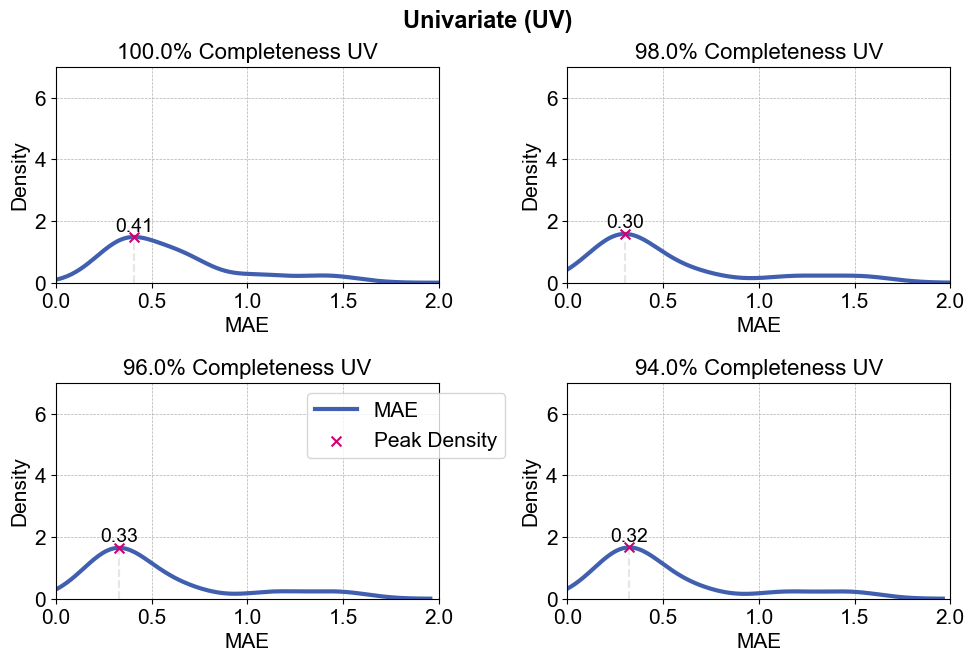

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
from eda_helper import get_custom_palette

custom_palette = get_custom_palette()

fig, ax = plt.subplots(2, 2, figsize=(10, 7))

for i, completeness in enumerate(performance["Completeness"].unique()):
    # Subset
    subset = performance[performance["Completeness"] == completeness]

    # Draw the density plot
    sns.kdeplot(subset["MAE"], linewidth=3, label="MAE", ax=ax[i // 2][i % 2])

    # Compute KDE values
    mae_values = np.linspace(subset["MAE"].min(), subset["MAE"].max(), 1000)
    kde_func = gaussian_kde(subset["MAE"].values)
    kde_values = kde_func(mae_values)

    # Find the MAE value with the maximum KDE
    max_mae_value = mae_values[np.argmax(kde_values)]
    max_kde_value = kde_values[np.argmax(kde_values)]

    # Plot the point at peak density
    ax[i // 2][i % 2].scatter(
        max_mae_value,
        max_kde_value,
        color=custom_palette[7],
        s=50,
        zorder=5,
        label="Peak Density",
        marker="x",
    )

    # Draw a vertical line from the scatter point
    ax[i // 2][i % 2].vlines(
        max_mae_value, 0, max_kde_value, linestyles="dashed", colors=custom_palette[4]
    )

    # Label the point with its x coordinate
    ax[i // 2][i % 2].text(
        max_mae_value,
        max_kde_value * 1.04,
        f"{max_mae_value:.2f}",
        ha="center",
        va="bottom",
        fontsize=14,
    )

    ax[i // 2][i % 2].set_title(f"{completeness*100}% Completeness UV")
    ax[i // 2][i % 2].grid(
        True, which="both", axis="both", linestyle="--", linewidth=0.5
    )
    ax[i // 2][i % 2].set_ylim(0, 7)
    ax[i // 2][i % 2].set_xlim(0, 2)

    if ax[i // 2][i % 2] == ax[1][0]:
        ax[i // 2][i % 2].legend(loc="upper right", bbox_to_anchor=(1.2, 1.0))

fig.suptitle("Univariate (UV)", y=0.95)

plt.tight_layout()  # Adjust the layout for better visualization
plt.show()

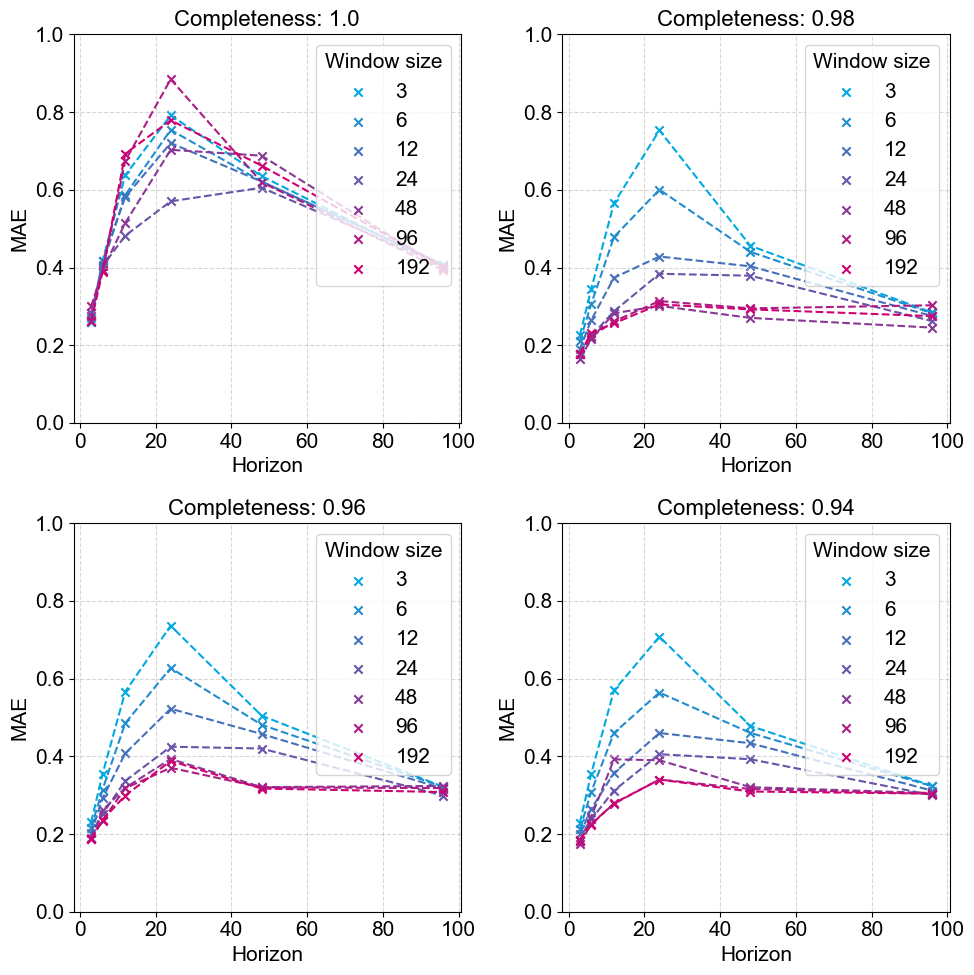

In [234]:
window_values = performance_lstm["WindowSize"].unique()
colors = custom_heatmap(
    np.linspace(0, 1, len(window_values))
)  # viridis colormap, you can choose any other

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, completeness in enumerate(performance_lstm["Completeness"].unique()):
    for j, window_size in enumerate(window_values):
        data = performance_lstm[
            (performance_lstm["Completeness"] == completeness)
            & (performance_lstm["WindowSize"] == window_size)
        ]

        label = window_size
        ax[i // 2, i % 2].scatter(
            data["Horizon"], data["MAE"], color=colors[j], label=label, marker="x"
        )
        ax[i // 2, i % 2].plot(
            data["Horizon"], data["MAE"], color=colors[j], linestyle="--"
        )

    ax[i // 2, i % 2].legend(title="Window size", loc="upper right")
    ax[i // 2, i % 2].set_title(f"Completeness: {completeness}")
    ax[i // 2, i % 2].set_xlabel("Horizon")
    ax[i // 2, i % 2].set_ylabel("MAE")
    ax[i // 2, i % 2].set_ylim(0, 1)
    ax[i // 2, i % 2].grid(True, axis="both", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

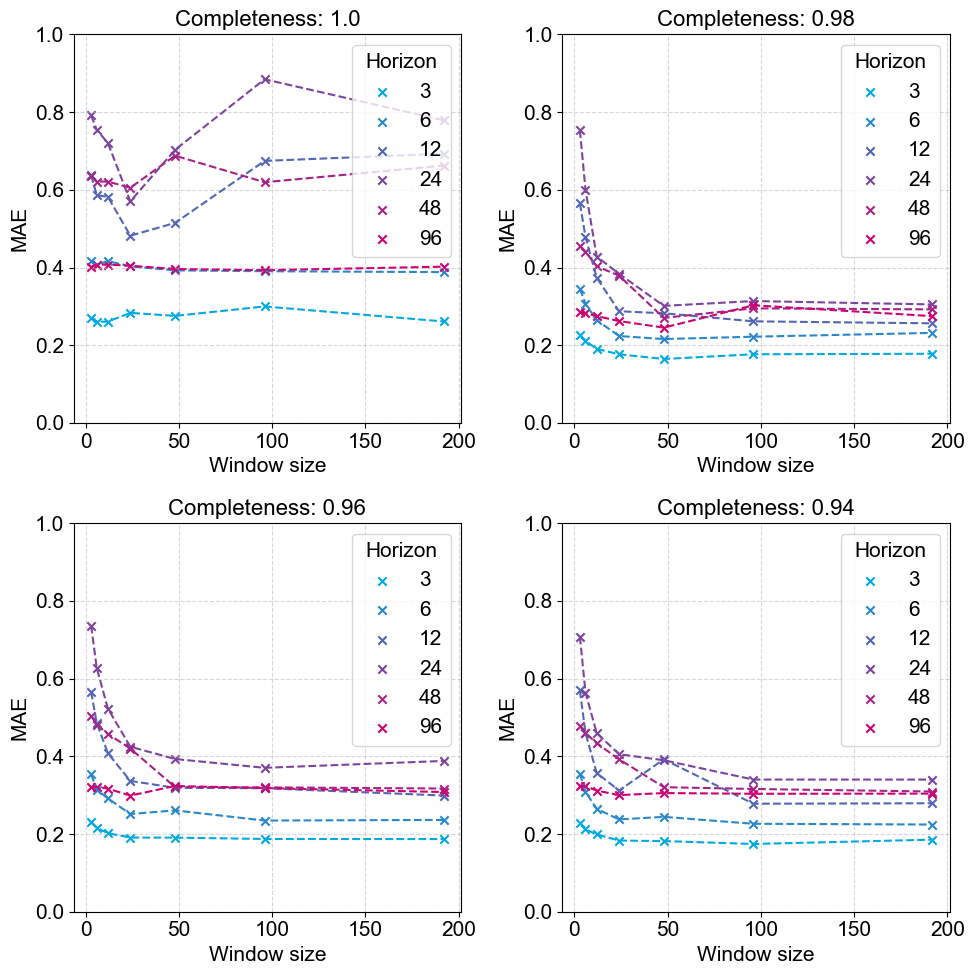

In [235]:
horizon_values = performance_lstm["Horizon"].unique()
colors = custom_heatmap(
    np.linspace(0, 1, len(horizon_values))
)  # viridis colormap, you can choose any other

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, completeness in enumerate(performance_lstm["Completeness"].unique()):
    for j, horizon in enumerate(horizon_values):
        data = performance_lstm[
            (performance_lstm["Completeness"] == completeness)
            & (performance_lstm["Horizon"] == horizon)
        ]

        label = horizon
        ax[i // 2, i % 2].scatter(
            data["WindowSize"], data["MAE"], color=colors[j], label=label, marker="x"
        )
        ax[i // 2, i % 2].plot(
            data["WindowSize"], data["MAE"], color=colors[j], linestyle="--"
        )

    ax[i // 2, i % 2].legend(title="Horizon", loc="upper right")
    ax[i // 2, i % 2].set_title(f"Completeness: {completeness}")
    ax[i // 2, i % 2].set_xlabel("Window size")
    ax[i // 2, i % 2].set_ylabel("MAE")
    ax[i // 2, i % 2].set_ylim(0, 1)
    ax[i // 2, i % 2].grid(True, which="both", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

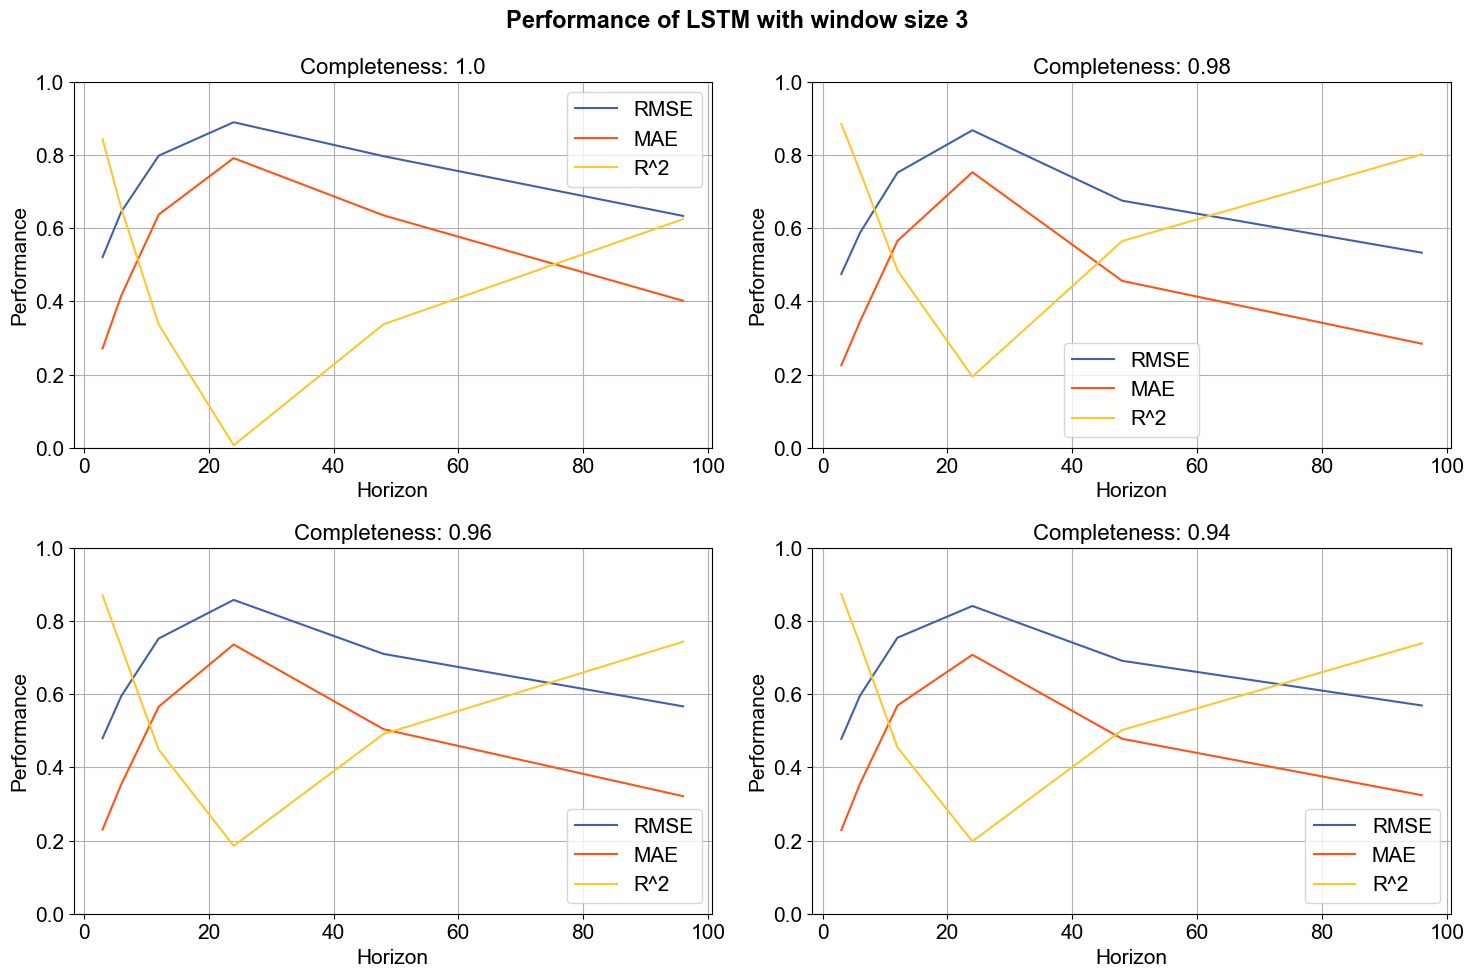

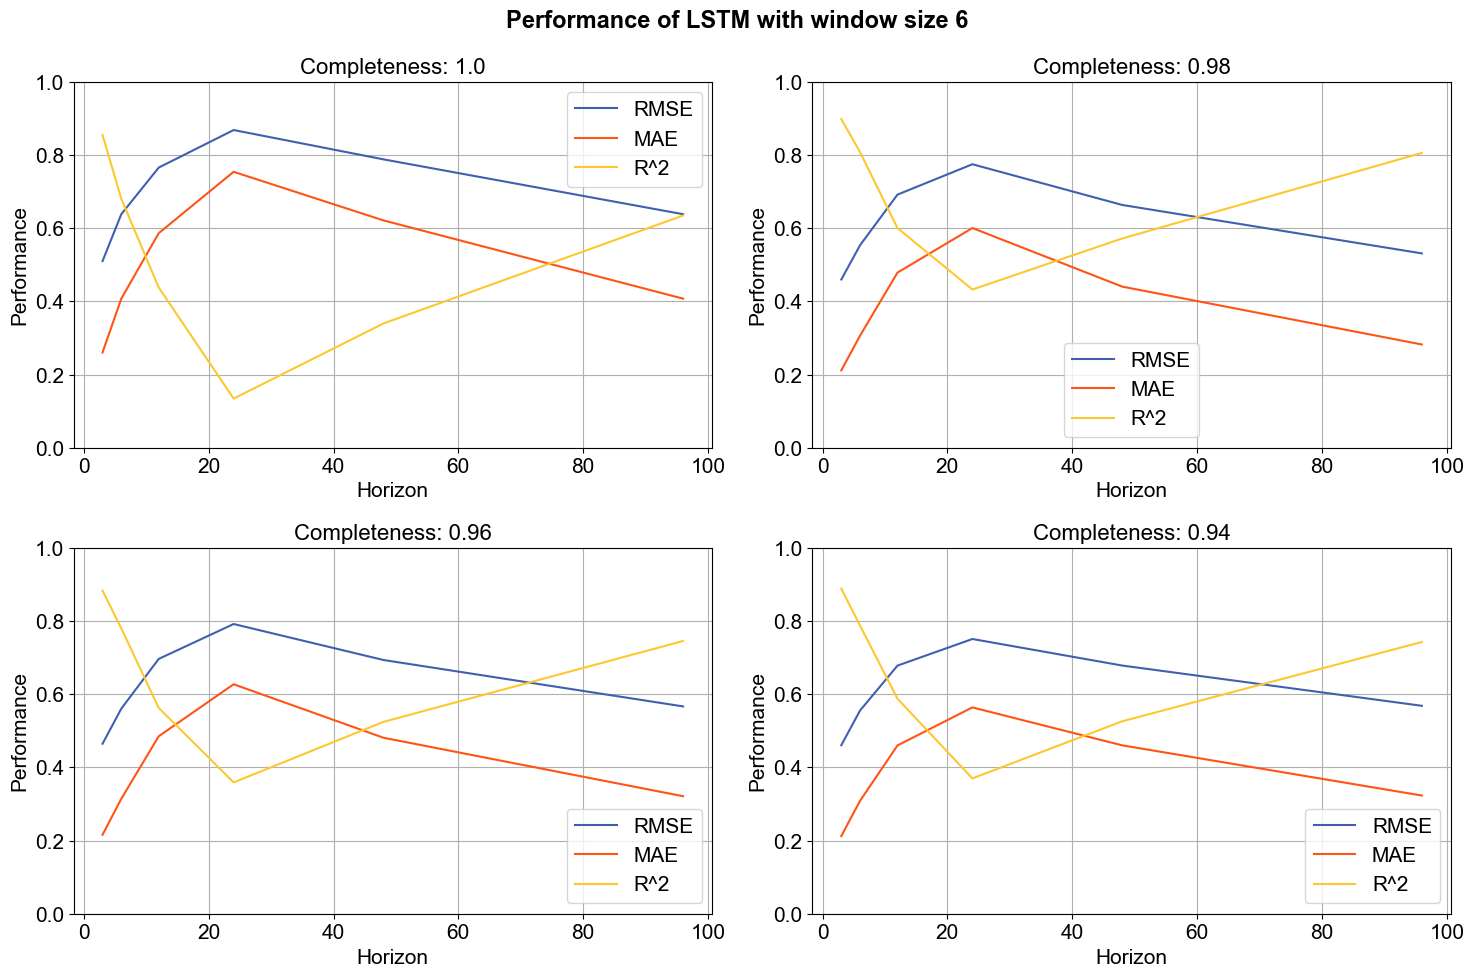

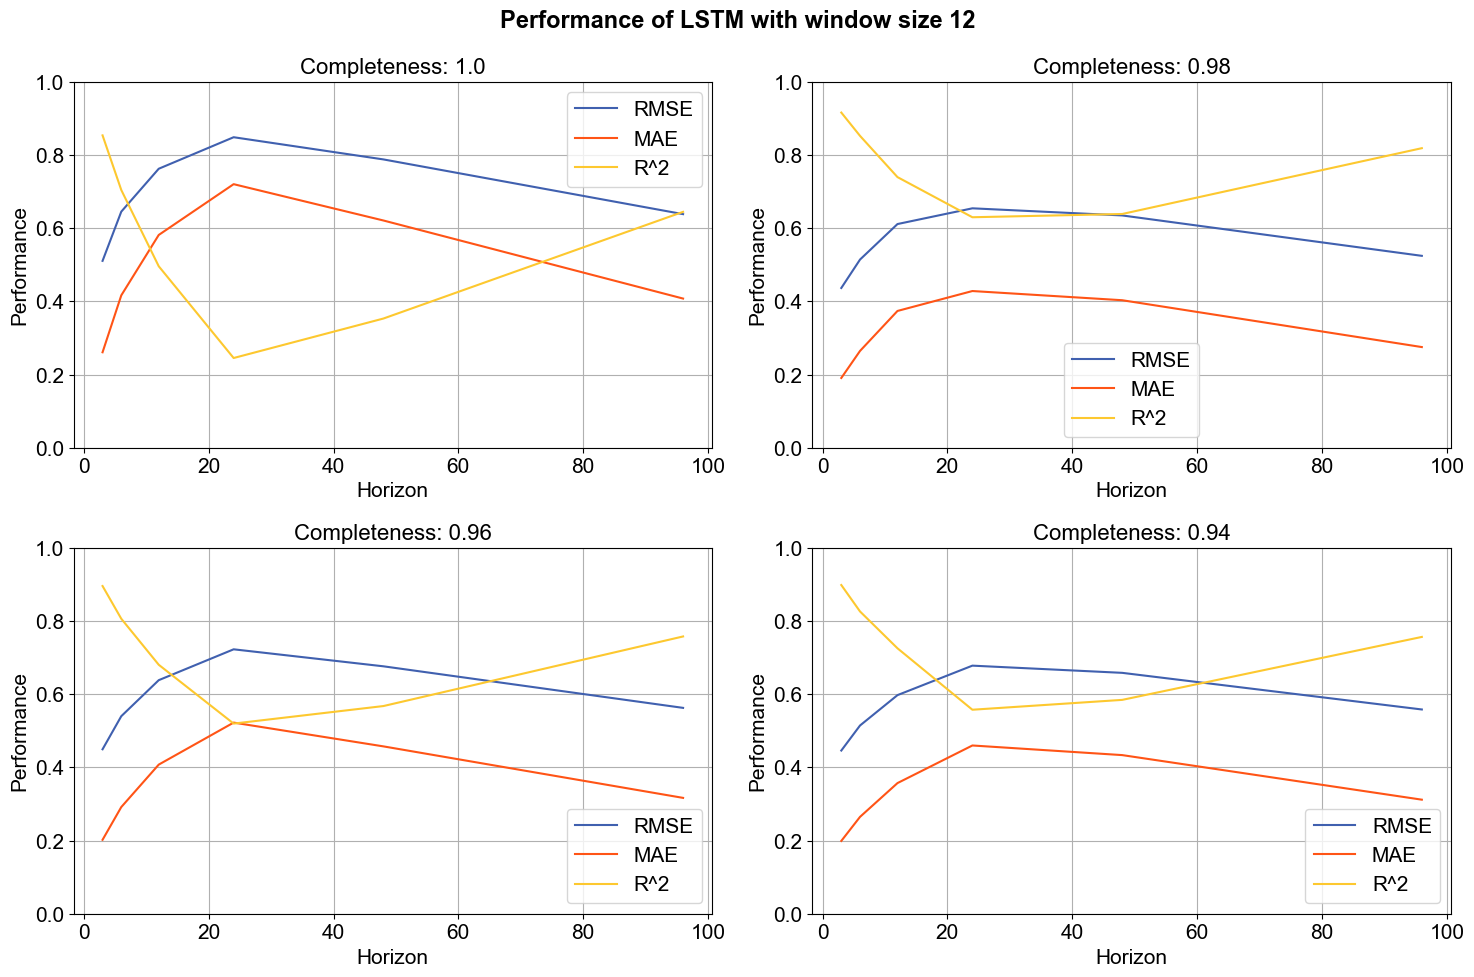

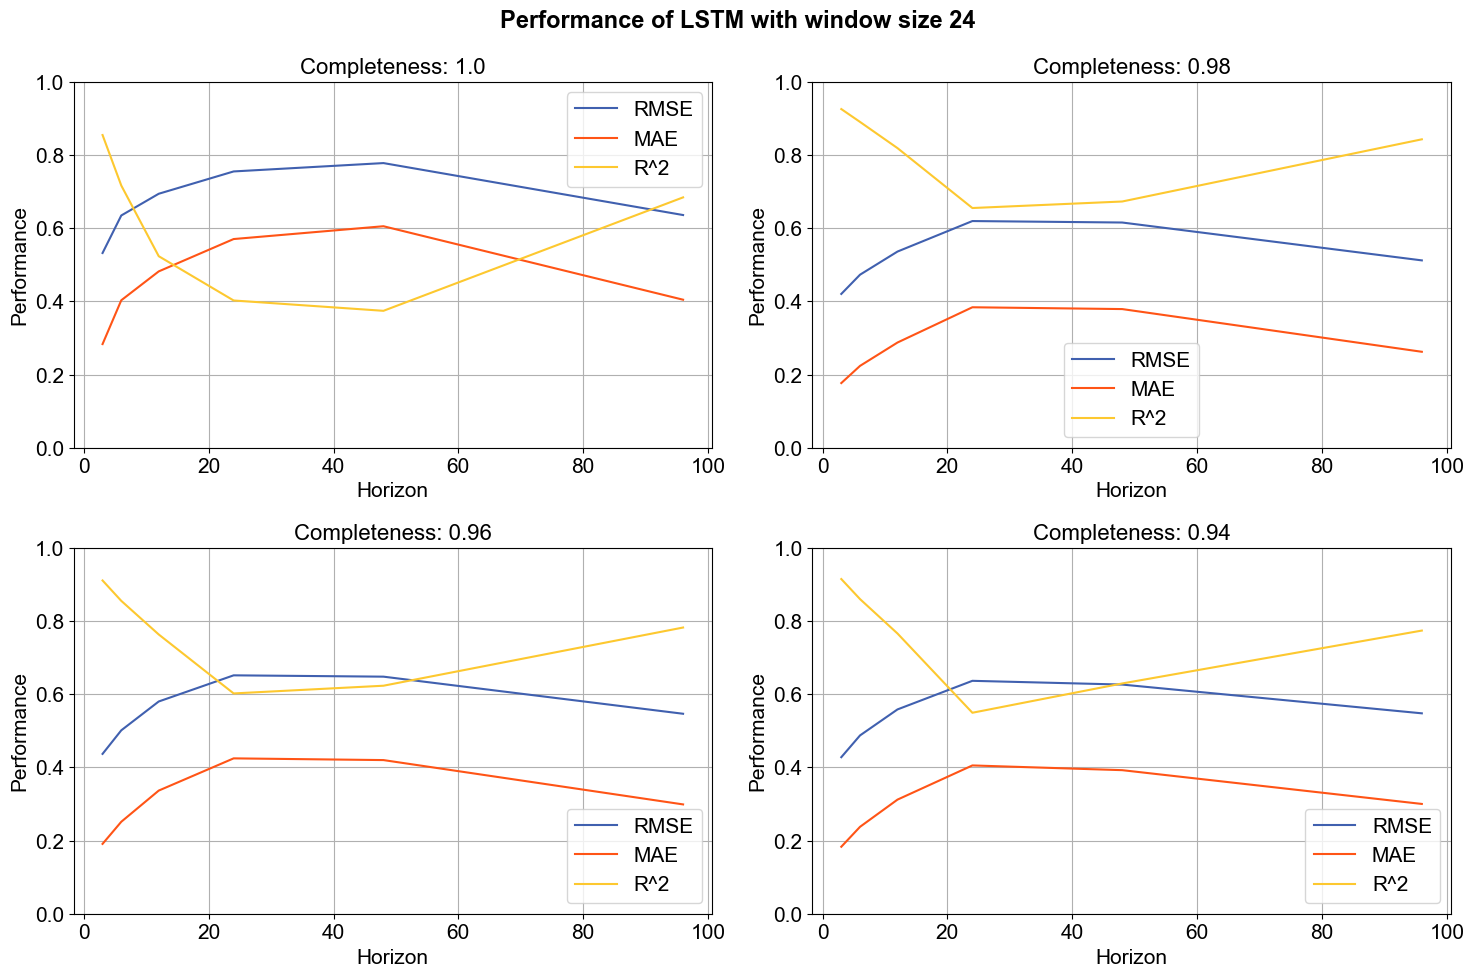

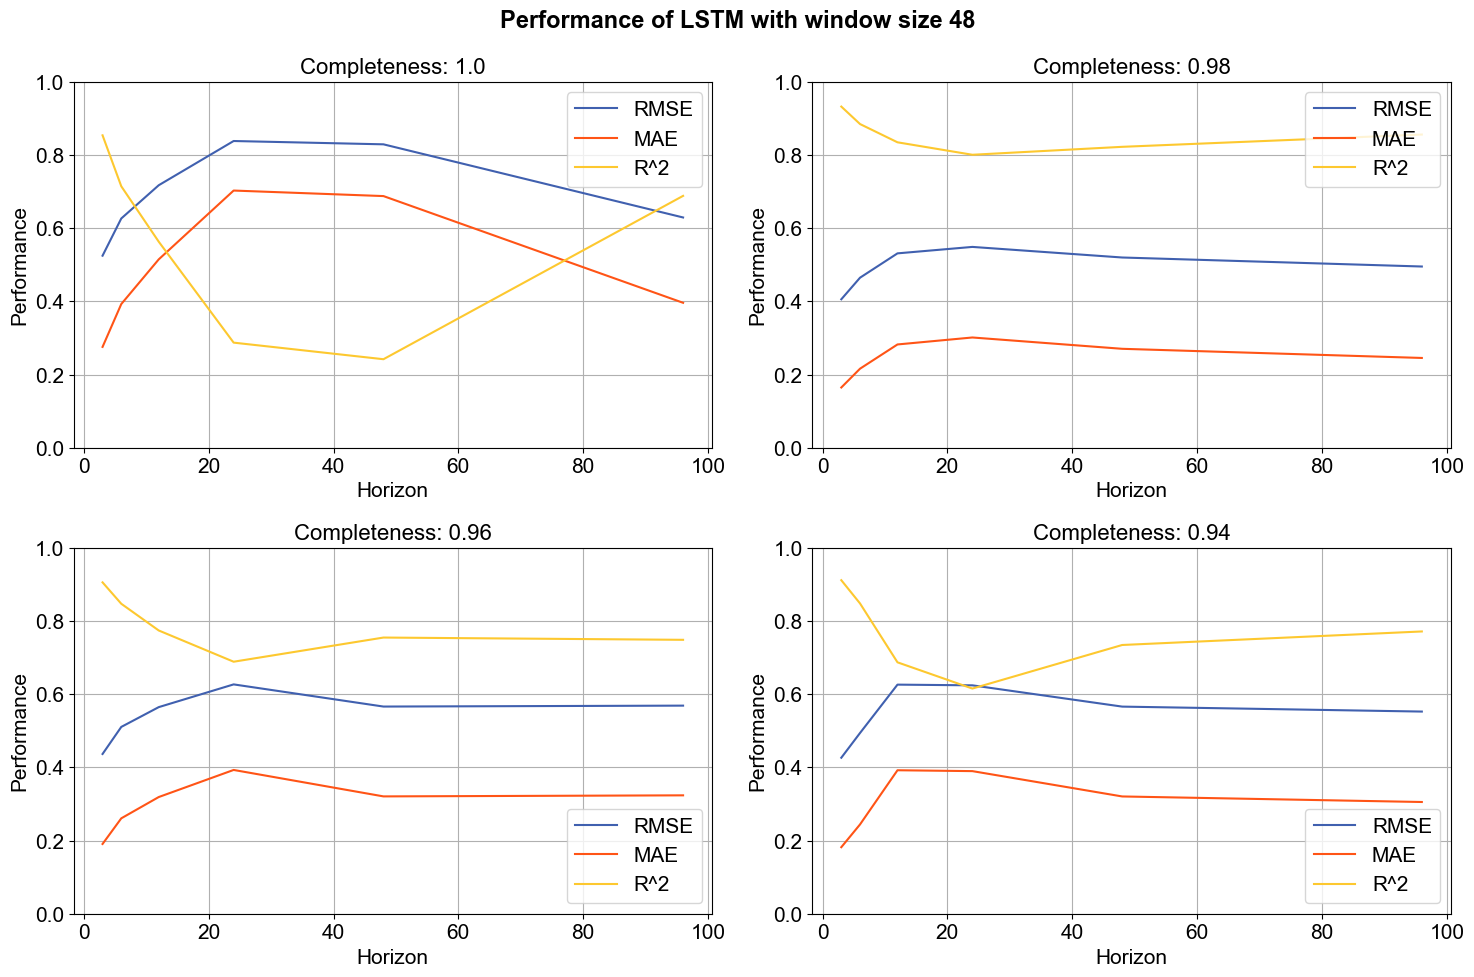

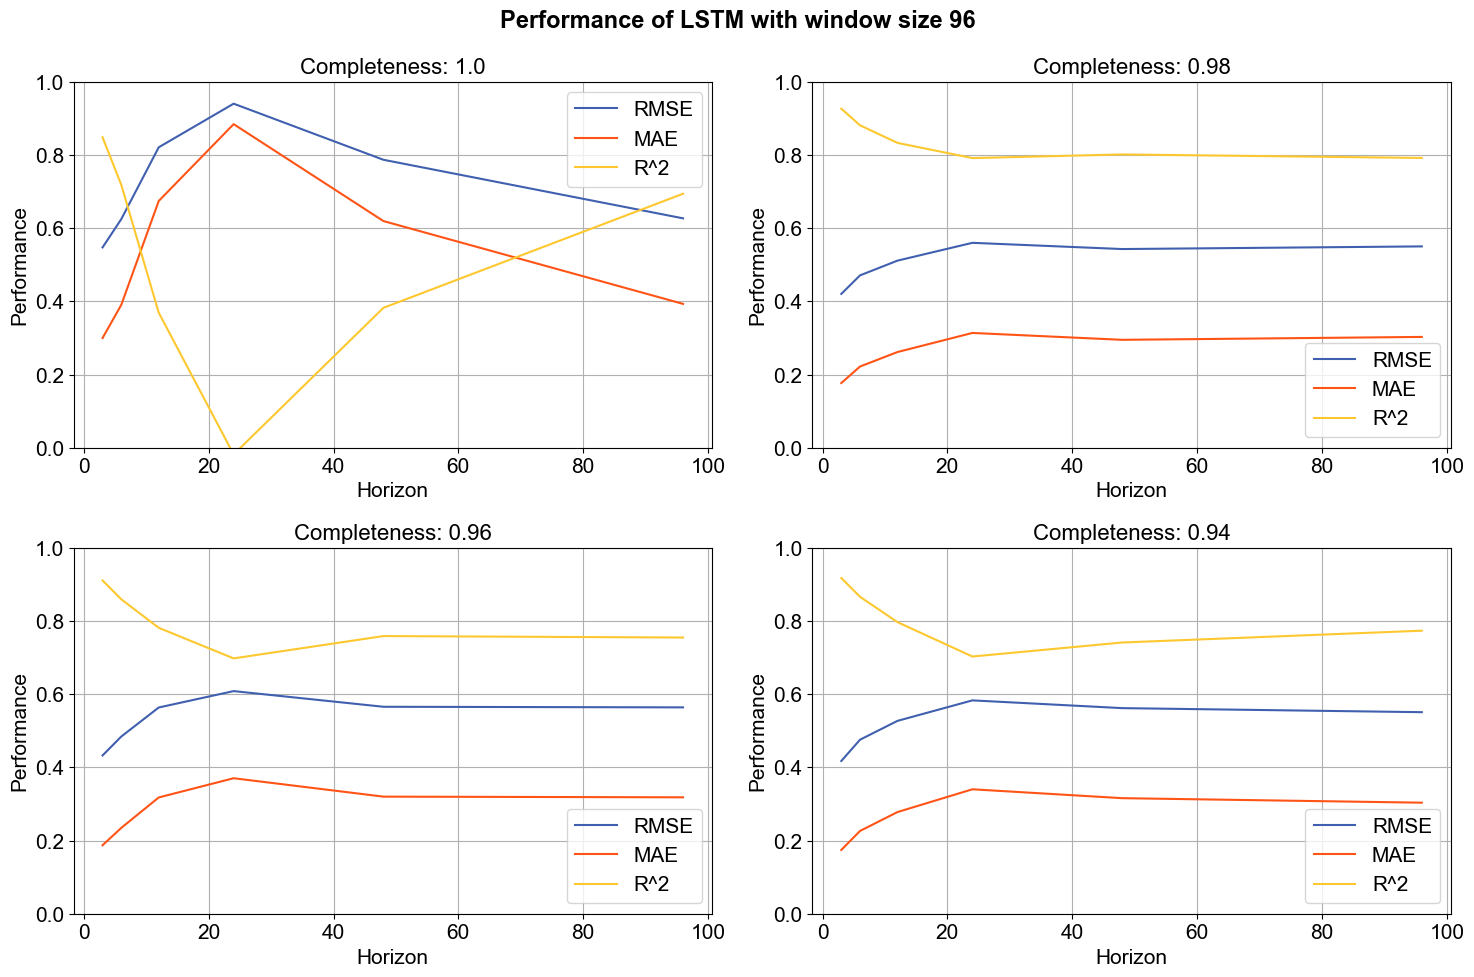

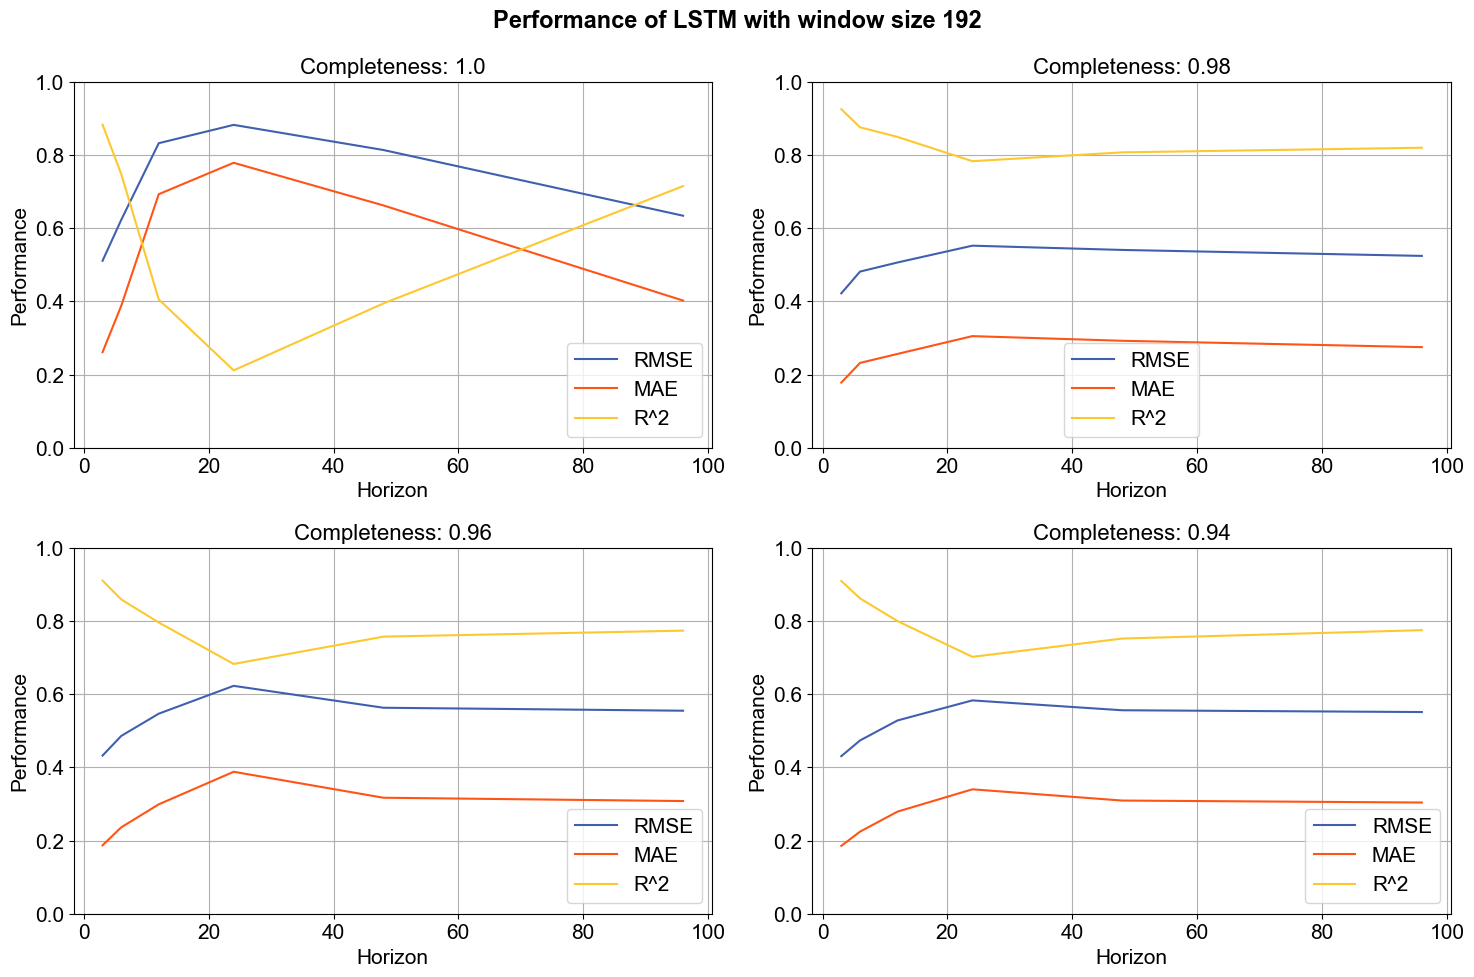

In [236]:
for i, window_size in enumerate(performance_lstm["WindowSize"].unique()):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    for i, completeness in enumerate(performance_lstm["Completeness"].unique()):
        data = performance_lstm[
            (performance_lstm["Completeness"] == completeness)
            & (performance_lstm["WindowSize"] == window_size)
        ]
        ax[i // 2][i % 2].plot(
            data["Horizon"], data["RMSE"], label="RMSE", color=custom_palette[0]
        )
        ax[i // 2][i % 2].plot(
            data["Horizon"], data["MAE"], label="MAE", color=custom_palette[1]
        )
        ax[i // 2][i % 2].plot(
            data["Horizon"], data["R^2"], label="R^2", color=custom_palette[2]
        )
        ax[i // 2][i % 2].set_title(f"Completeness: {completeness}")
        ax[i // 2][i % 2].set_xlabel("Horizon")
        ax[i // 2][i % 2].set_ylabel("Performance")
        ax[i // 2][i % 2].legend()
        ax[i // 2][i % 2].grid()
        ax[i // 2][i % 2].set_ylim([0, 1])
    fig.suptitle(f"Performance of LSTM with window size {window_size}")
    fig.tight_layout()

C:\Users\carro\AppData\Local\Temp\ipykernel_22764\491167414.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


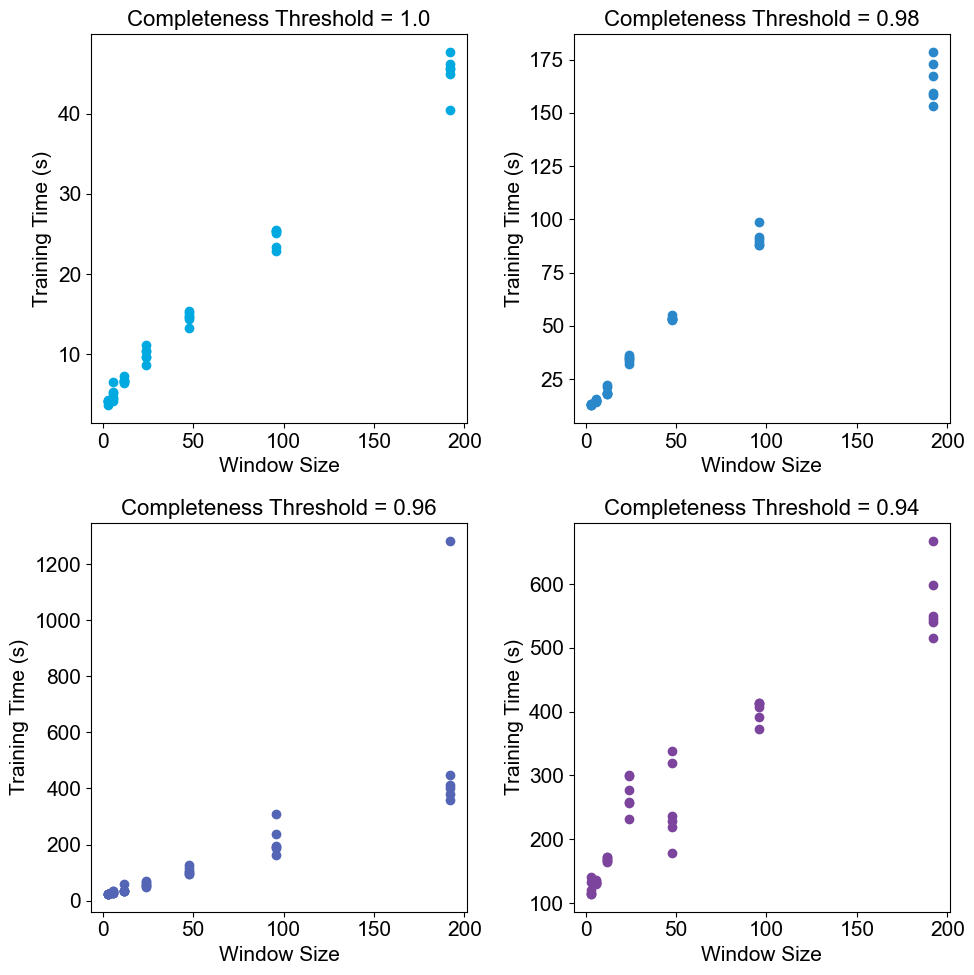

In [237]:
colors = custom_heatmap(np.linspace(0, 1, len(horizon_values)))
window_sizes = performance_lstm["WindowSize"].unique()
horizons = performance_lstm["Horizon"].unique()
completeness_thresholds = performance_lstm["Completeness"].unique()
# Plotting
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for i, completeness_threshold in enumerate(completeness_thresholds):
    ax[i // 2, i % 2].scatter(
        performance_lstm[performance_lstm["Completeness"] == completeness_threshold][
            "WindowSize"
        ],
        performance_lstm[performance_lstm["Completeness"] == completeness_threshold][
            "Training Time (s)"
        ],
        color=colors[i],
        label=performance_lstm[
            performance_lstm["Completeness"] == completeness_threshold
        ]["Horizon"].unique()[i],
    )
    ax[i // 2, i % 2].set_title(f"Completeness Threshold = {completeness_threshold}")
    ax[i // 2, i % 2].set_xlabel("Window Size")
    ax[i // 2, i % 2].set_ylabel("Training Time (s)")
    # ax[i // 2, i % 2].legend()

fig.tight_layout()
fig.show()